In [12]:
import numpy as np
from numpy import pi
from qiskit.visualization import plot_circuit_layout, plot_histogram
from qiskit import transpile
#from qiskit.providers.aer import AerSimulator
from qiskit import QuantumCircuit

In [3]:
import sys
sys.path.append("..")
import fakeutils, mock_backend
from fakeutils.gate_map import plot_gate_map

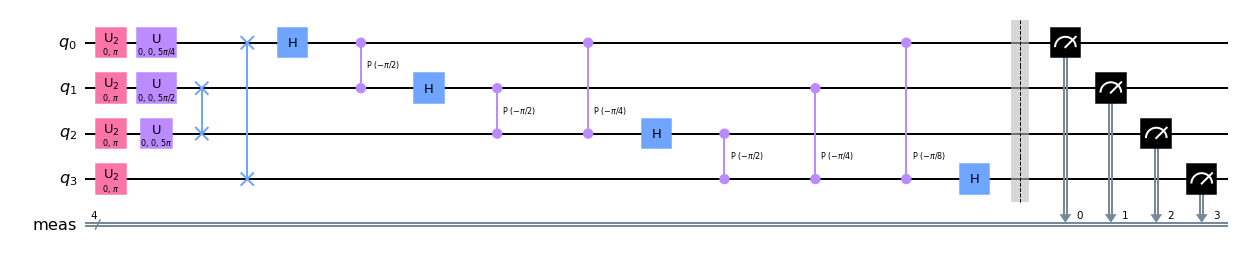

In [4]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

def getQFTCircuit(nqubits=4, number=5):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    qc.p(number*pi/4,0)
    qc.p(number*pi/2,1)
    qc.p(number*pi,2)

    qc = inverse_qft(qc, nqubits)
    qc.measure_all()
    return qc

example = getQFTCircuit()
example.draw(output='mpl')

In [13]:
# from mock_backend import LegacyFakeHatlab, FakeHatlab
# hatlab_backend = FakeHatlab()
# printing_backend = LegacyFakeHatlab()
# plot_gate_map(printing_backend, qubit_coordinates= printing_backend.qubit_coordinates)
# backend = hatlab_backend

from qiskit.test.mock import FakeMumbai #, FakeMumbaiV2
backend = FakeMumbai() #FakeMumbaiV2()
plot_gate_map(FakeMumbai())
backend.configuration().basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']

In [7]:
# sim_backend = AerSimulator.from_backend(backend)

In [16]:
#target basis
# print(backend.configuration().basis_gates)
print(backend.operation_names)

This backend's operations: rx,ry,cz,measure only apply to a subset of qubits. Using this property to get 'basis_gates' for the transpiler may potentially create invalid output


['rx', 'ry', 'id', 'swap', 'cz', 'reset', 'measure']


In [17]:
qc = getQFTCircuit(nqubits=8, number=5)
transpiled_qc = transpile(qc, backend, optimization_level=3)
# from qiskit.transpiler import PassManager
# from qiskit.transpiler.passes import ApplyLayout #,BasisTranslator
# from fakeutils.fakeutils import BasisTranslator
# from fakeutils.nonglobal_trivial_layout import NonGlobalTrivialLayout
# from qiskit.circuit.library.standard_gates.equivalence_library import (
#     StandardEquivalenceLibrary,
# )
# layout_analysis = NonGlobalTrivialLayout(backend.target)
# apply_pass = ApplyLayout()
# basis_pass = BasisTranslator(StandardEquivalenceLibrary, None, target=backend.target)
# pm = PassManager([layout_analysis, apply_pass, basis_pass])
# pm = PassManager([basis_pass])
# transpiled_qc = pm.run(qc)
transpiled_qc.draw('mpl')

KeyboardInterrupt: 

In [ ]:
optimized_0 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=0)
print('gates = ', optimized_0.count_ops())
print('depth = ', optimized_0.depth())
optimized_3 = transpile(qc, backend=backend, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

gates =  OrderedDict([('rz', 48), ('sx', 30), ('cx', 21), ('measure', 3), ('barrier', 1)])
depth =  79
gates =  OrderedDict([('rz', 17), ('cx', 15), ('sx', 6), ('measure', 3), ('barrier', 1)])
depth =  29


In [ ]:
from qiskit.tools.monitor import job_monitor
shots = 2048
job = sim_backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


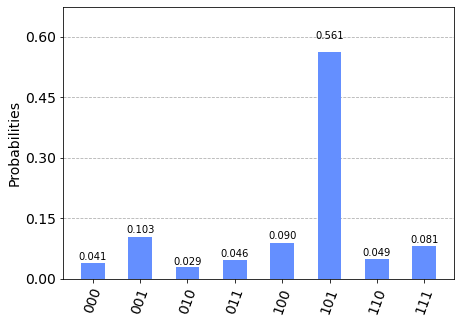

In [ ]:
counts = job.result().get_counts()
plot_histogram(counts)